In [57]:
# Hi-C class script
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
import argparse
import itertools
import random

data_path = "/Users/ninaxiong/projects/HST508_Fall2022_final_project/data/ENCODE_bulk_rna_seq.csv"
gene_loc_path = "/Users/ninaxiong/projects/HST508_Fall2022_final_project/data/gene_locations.tsv"
tad_path = "/Users/ninaxiong/projects/HST508_Fall2022_final_project/data/TAD_strong_boundary_start_end.csv"
chrlen_path = "/Users/ninaxiong/projects/HST508_Fall2022_final_project/data/chr_lengths"

In [63]:
# read in data
tpm_data, gene_loc_data, tad_data = extract_data(data_path, gene_loc_path, tad_path)
# normalize tpm data
norm_tpm = log2norm_tpm(tpm_data)
# make dictionaries
cg_dict = chromosome_gene_dict(gene_loc_data)
tg_dict = tad_gene_dict(tad_data,gene_loc_data)

chromosome_list = ['chr'+str(i+1) for i in range(19)]

/var/folders/gn/1dwlg7ns6s3d_22hhl8kmrwm0000gn/T/ipykernel_1734/4172375163.py:41: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  sc_df_filtered = sc_df_filtered.loc[gene_list]
/var/folders/gn/1dwlg7ns6s3d_22hhl8kmrwm0000gn/T/ipykernel_1734/4172375163.py:42: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  gloc_filtered = gloc_filtered.loc[gene_list]


In [59]:
# for chromosome in chromosome_list:
#     tpm, gene_loc, tad = get_genes_from_chromosome(chromosome,norm_tpm,tad_data,gene_loc_data)
#     for t in tad.index:
#         if t not in tg_dict.keys():
#             continue
#         tad_chr, tad_start, tad_end = tad.loc[t,:]
#         tad_corr_df = calc_tad_coexp(tad_chr, tad_start, tad_end, gene_loc_data, tpm)
#         new_boundaries, slide_distances = slide_boundary(tad_chr, tad_start, tad_end, 20)
#         distances = [0] + slide_distances
#         corr = [get_upper_triangle(tad_corr_df)]
#         for new_chr, new_start, new_end in new_boundaries:
#             new_corr_df = calc_tad_coexp(new_chr, new_start, new_end, gene_loc_data, tpm)
#             corr.append(get_upper_triangle(new_corr_df))
#         tad_location = "{}_{}-{}".format(tad_chr, tad_start, tad_end)
#         # plot_tad_heatmap(tad_location, tad_corr_df)
#         plot_corr_distance(tad_location, np.array(distances)/1000 , corr)

In [69]:
def high_low_corr_genes(corr_df, percentile, high=True):
    """
    if high, return all gene pairs greater than percentile
    if low, return all gene pairs less than percentile
    """
    corr_matrix = corr_df.to_numpy()
    values = corr_matrix[np.triu_indices_from(corr_matrix, 1)].flatten()
    threshold = np.percentile(values, percentile)
    genes = corr_df.index
    all_pairs = list(itertools.combinations(genes, 2))
    correlated_gene_pairs = []
    for pair in all_pairs:
        gene1, gene2 = pair[0], pair[1]
        corr = corr_df.loc[gene1,gene2]
        if high:
            if corr > threshold and corr < 0.99:
                correlated_gene_pairs.append((gene1,gene2))
        else:
            if corr < threshold:
                correlated_gene_pairs.append((gene1,gene2))
    return correlated_gene_pairs

pairs_in_tad = []
for pair in correlated_gene_pairs:
    if genes_in_same_tad(pair, tg_dict):
        pairs_in_tad.append(pair)
return len(pairs_in_tad) / len(correlated_gene_pairs)

In [71]:
high = []
low = []
for chromosome in chromosome_list:
    tpm, gene_loc, tad = get_genes_from_chromosome(chromosome,norm_tpm,tad_data,gene_loc_data)
    all_genes_corr_df = tpm.transpose().corr()
    high.append(high_low_corr_genes(all_genes_corr_df, 99, True))
    low.append(high_low_corr_genes(all_genes_corr_df, 1, False))

In [72]:
df = pd.DataFrame({"chr": chromosome_list, "top_1": high, "bottom_1": low})
df

,chr,top_1,bottom_1
0,chr1,0.006046,0.000499
1,chr2,0.004501,0.000751
2,chr3,0.007922,0.000792
3,chr4,0.006109,0.001150
4,chr5,0.006877,0.001022
5,chr6,0.013206,0.001031
6,chr7,0.007591,0.000957
7,chr8,0.007888,0.000536
8,chr9,0.003809,0.001237
9,chr10,0.007444,0.001573


In [93]:
def get_gene_pairs(genes):
    """
    given a list of genes, return all possible pairs (not including self pairs)
    """
    return list(itertools.combinations(genes, 2))

def get_random_gene_pairs(genes, tg_dict, num_pairs=100):
    """
    given a list of genes, return a random list of gene pairs that are not located in TADs
    """
    gene_pairs = []
    count = 0
    while count < num_pairs:
        gene1 = random.choice(genes)
        gene2 = random.choice(genes)
        if not genes_in_same_tad((gene1, gene2), tg_dict) and gene1 != gene2:
            gene_pairs.append((gene1, gene2))
            count += 1
    return gene_pairs

def get_prop_hc_genes(gene_pairs, hc_gene_pairs):
    """
    return proportion of gene pairs that are highly correlated
    """
    hc_count = 0
    for pair in gene_pairs:
        if pair in hc_gene_pairs:
            hc_count += 1
    return hc_count / len(gene_pairs)

def plot_prop_hc_genes(all_genes_corr_df):
    """
    plot distribution of HC gene pair proportion in TAD vs random gene pairs
    """
    hc_gene_pairs = high_low_corr_genes(all_genes_corr_df, 90)

    tad_prop_hc_genes = []
    random_prop_hc_genes = []

    for t in tad.index:
        if t not in tg_dict.keys():
            continue
        tad_chr, tad_start, tad_end = tad.loc[t,:]

        tad_gene_pairs = get_gene_pairs(get_genes_in_interval(tad_chr, tad_start, tad_end, gene_loc))
        if len(tad_gene_pairs) == 0:
            continue
        random_gene_pairs = get_random_gene_pairs(gene_loc.index, tg_dict, len(tad_gene_pairs))

        tad_prop_hc_genes.append(get_prop_hc_genes(tad_gene_pairs, hc_gene_pairs))
        random_prop_hc_genes.append(get_prop_hc_genes(random_gene_pairs, hc_gene_pairs))

    df = pd.DataFrame({"TAD": tad_prop_hc_genes, "random": random_prop_hc_genes})
    df.plot.hist(alpha=0.5)
    plt.xlabel("Proportion of HC gene pairs")
    plt.ylabel("Frequency")
    plt.title(chromosome)
    plt.legend(loc="upper right")
    plt.show()
    

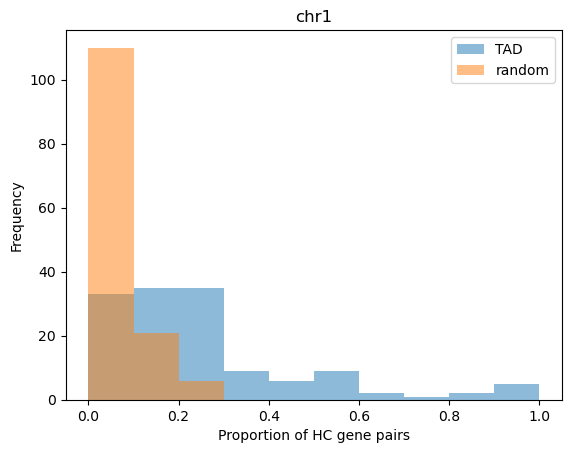

In [94]:
for chromosome in chromosome_list:
    tpm, gene_loc, tad = get_genes_from_chromosome(chromosome,norm_tpm,tad_data,gene_loc_data)
    all_genes_corr_df = tpm.transpose().corr()
    
    plot_prop_hc_genes(all_genes_corr_df)
    break